In [1]:
import string
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
#from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
#from tensorflowkeras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)


# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [3]:
annotations_path = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"

In [4]:
import json

In [5]:
with open(annotations_path, "r") as f:
    annotations = json.load(f)

In [6]:
image_ids = []
captions = []
idxs = []
for idx, annotation in enumerate(annotations["annotations"]):
    if idx == 40000:
        break
    image_ids.append(annotation["image_id"])
    captions.append(annotation["caption"])
    idxs.append(idx)

In [7]:
image_paths = []
for image_id in image_ids:
    image_filename = f"{str(image_id).zfill(12)}.jpg"
    image_path = f"/kaggle/input/coco-2017-dataset/coco2017/train2017/{image_filename}"
    image_paths.append(image_path)

In [8]:
df = []
for i in idxs :
    emp = []
    emp.append(f'{image_paths[i]}')
    emp.append(f'{i}')
    emp.append(f'{captions[i]}')
    df.append(emp)

In [9]:
df[:5]

[['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000203564.jpg',
  '0',
  'A bicycle replica with a clock as the front wheel.'],
 ['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000322141.jpg',
  '1',
  'A room with blue walls and a white sink and door.'],
 ['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000016977.jpg',
  '2',
  'A car that seems to be parked illegally behind a legally parked car'],
 ['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000106140.jpg',
  '3',
  'A large passenger airplane flying through the air.'],
 ['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000106140.jpg',
  '4',
  'There is a GOL plane taking off in a partly cloudy sky.']]

In [10]:
data = pd.DataFrame(df, columns=["filename","index","caption"])

In [11]:
data

filename  index  \
0      /kaggle/input/coco-2017-dataset/coco2017/train...      0   
1      /kaggle/input/coco-2017-dataset/coco2017/train...      1   
2      /kaggle/input/coco-2017-dataset/coco2017/train...      2   
3      /kaggle/input/coco-2017-dataset/coco2017/train...      3   
4      /kaggle/input/coco-2017-dataset/coco2017/train...      4   
...                                                  ...    ...   
39995  /kaggle/input/coco-2017-dataset/coco2017/train...  39995   
39996  /kaggle/input/coco-2017-dataset/coco2017/train...  39996   
39997  /kaggle/input/coco-2017-dataset/coco2017/train...  39997   
39998  /kaggle/input/coco-2017-dataset/coco2017/train...  39998   
39999  /kaggle/input/coco-2017-dataset/coco2017/train...  39999   

                                                 caption  
0      A bicycle replica with a clock as the front wh...  
1      A room with blue walls and a white sink and door.  
2      A car that seems to be parked illegally behind...  
3      A large passenger airplane flying through the ...  
4      There is a GOL plane taking off in a partly cl...  
...                                                  ...  
39995  There is a green bus stopped next to a brick b...  
39996   a couple of trains going in different directions  
39997  A row of blue and white airplanes on runway ne...  
39998    A chrome fire hydrant is on a crowded sidewalk.  
39999  Several benches and plants on a cobblestone pa...  

[40000 rows x 3 columns]

In [12]:
# Reordering columns for better readability
data = data.reindex(columns =['index','filename','caption'])

In [13]:
data.head()

index                                           filename  \
0     0  /kaggle/input/coco-2017-dataset/coco2017/train...   
1     1  /kaggle/input/coco-2017-dataset/coco2017/train...   
2     2  /kaggle/input/coco-2017-dataset/coco2017/train...   
3     3  /kaggle/input/coco-2017-dataset/coco2017/train...   
4     4  /kaggle/input/coco-2017-dataset/coco2017/train...   

                                             caption  
0  A bicycle replica with a clock as the front wh...  
1  A room with blue walls and a white sink and door.  
2  A car that seems to be parked illegally behind...  
3  A large passenger airplane flying through the ...  
4  There is a GOL plane taking off in a partly cl...

In [14]:
# If any filename dosn't have .jpg extension at last then mark it as Invalid filename
def invalid_filename_check(data):
  for filenames in data["filename"]:
    found = re.search("(.(jpg)$)", filenames)
    if (found):
        pass
    else:
        print("Error file: {}".format(filenames))

In [15]:
invalid_filename_check(data)

In [16]:
def utility_counter(data):

  unique_filenames = np.unique(data.filename.values)
  print("The number of unique file names : {}".format(len(unique_filenames)))

  print("The distribution of the number of captions for each image:")
  ct = Counter(Counter(data.filename.values).values())
  print(ct)
  return unique_filenames

In [17]:
unique_filenames = utility_counter(data)

The number of unique file names : 8054
The distribution of the number of captions for each image:
Counter({5: 7869, 4: 94, 2: 24, 3: 24, 6: 22, 1: 20, 7: 1})


In [18]:
#Function to plot the images and its description
# https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html
def image_desc_plotter(data):
  npic = 5
  npix = 224
  target_size = (npix,npix,3)

  count = 1
  fig = plt.figure(figsize=(10,20))
  for jpgfnm in unique_filenames[0:5]:
      filename = jpgfnm
      captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
      image_load = load_img(filename, target_size=target_size)
      
      ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
      ax.imshow(image_load)
      count += 1
      
      ax = fig.add_subplot(npic,2,count)
      plt.axis('off')
      ax.plot()
      ax.set_xlim(0,1)
      ax.set_ylim(0,len(captions))
      for i, caption in enumerate(captions):
          ax.text(0,i,caption,fontsize=20)
      count += 1
  plt.show()

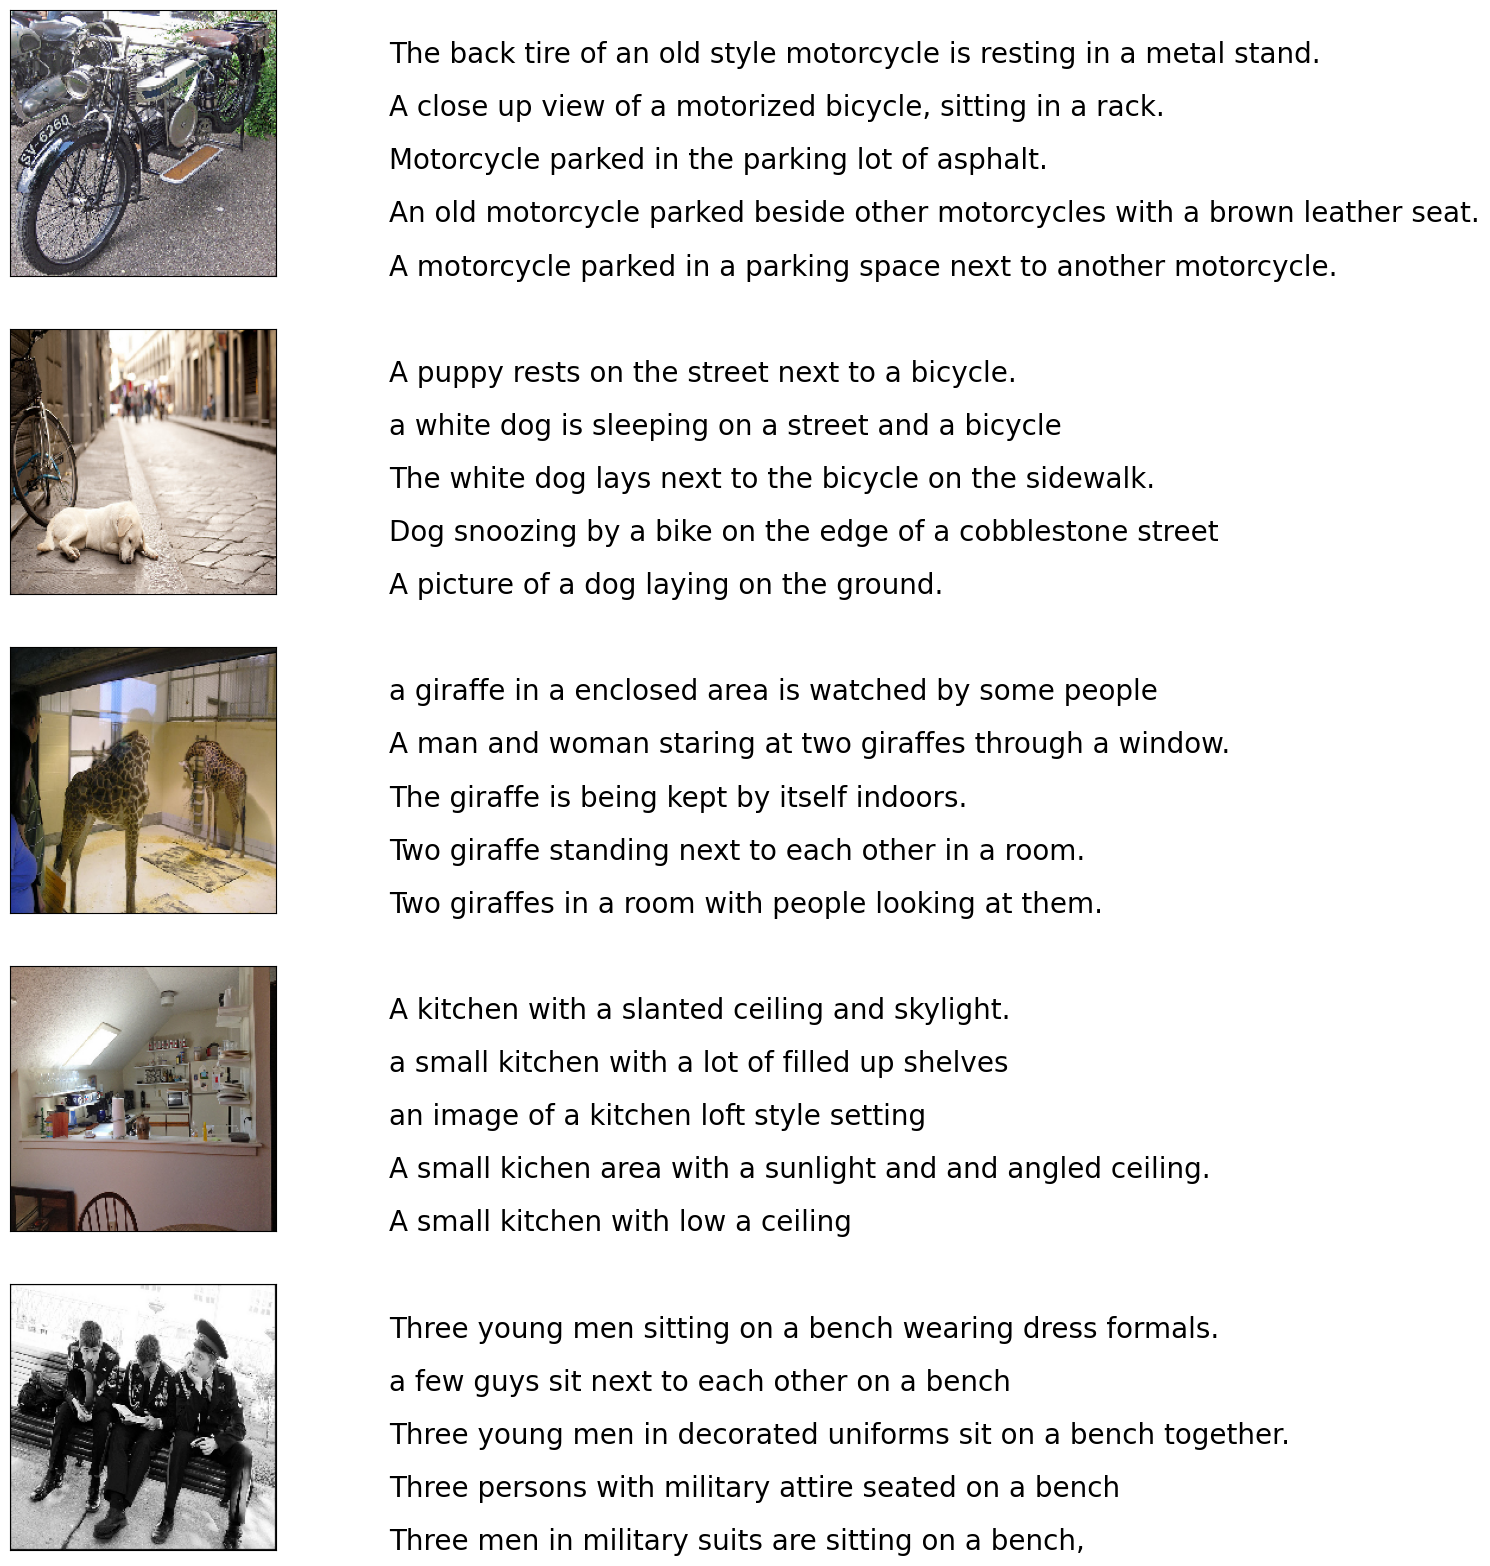

In [19]:
image_desc_plotter(data)

In [20]:
def create_vocabulary(data):
  vocab = []
  for captions in data.caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [21]:
vocabulary = create_vocabulary(data)

Vocabulary Size : 13734


In [22]:
vocabulary[:5]

['A', 'bicycle', 'replica', 'with', 'a']

In [23]:
def df_word_count(data,vocabulary):
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

In [24]:
dfwordcount = df_word_count(data,vocabulary)

In [25]:
dfwordcount.iloc[:10,:]

word  count
0     a  42202
1     A  23696
2    on  13013
3    of  12933
4   the  12478
5    in  12251
6  with  11281
7   and  10675
8    is   6159
9    to   4865

In [26]:
from wordcloud import WordCloud

In [27]:
word_freq = dfwordcount.set_index('word')['count'].to_dict()

In [28]:
word_freq['a']

42202

In [29]:
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(word_freq)

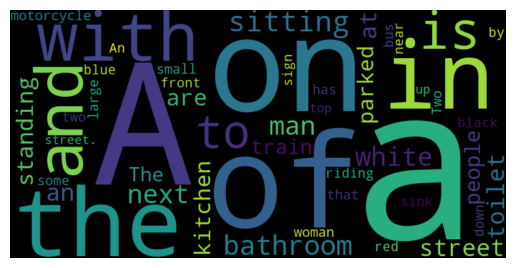

In [30]:
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

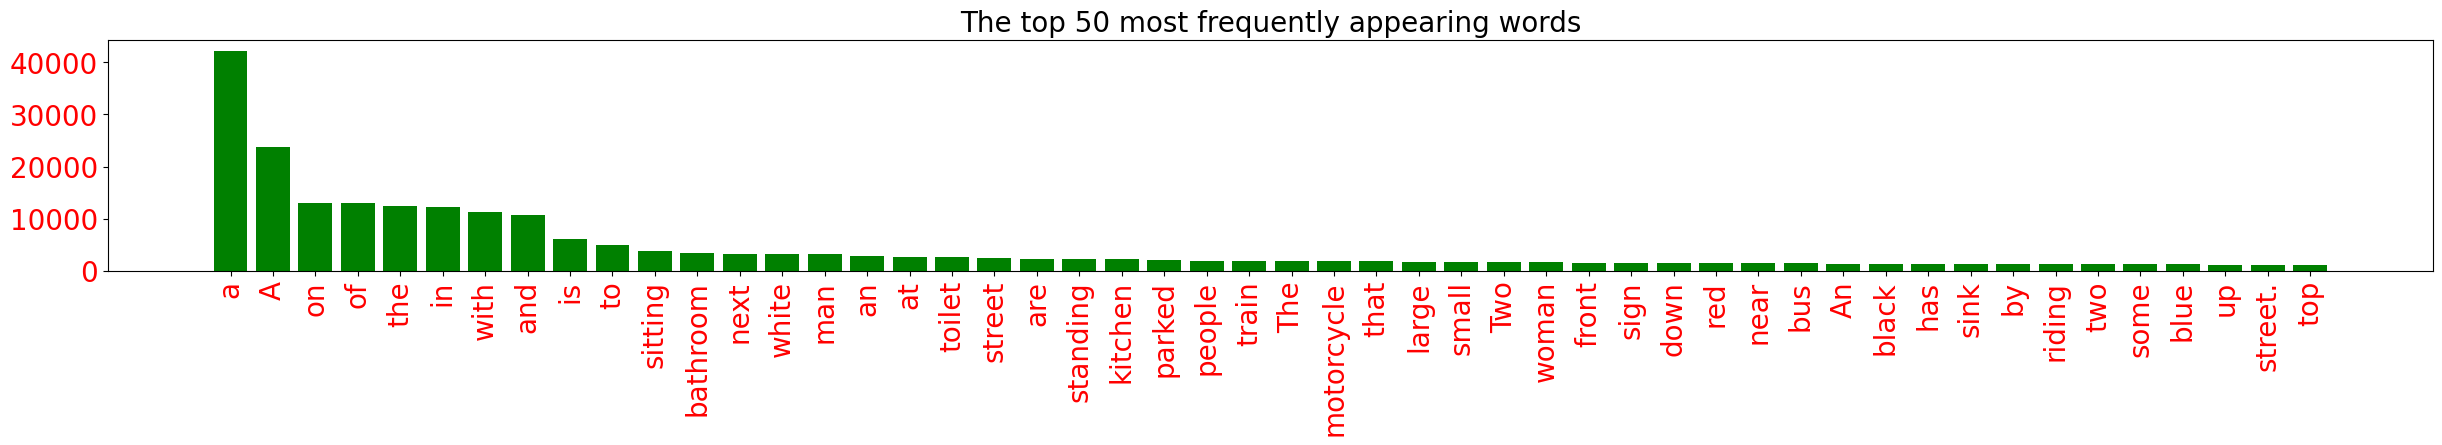

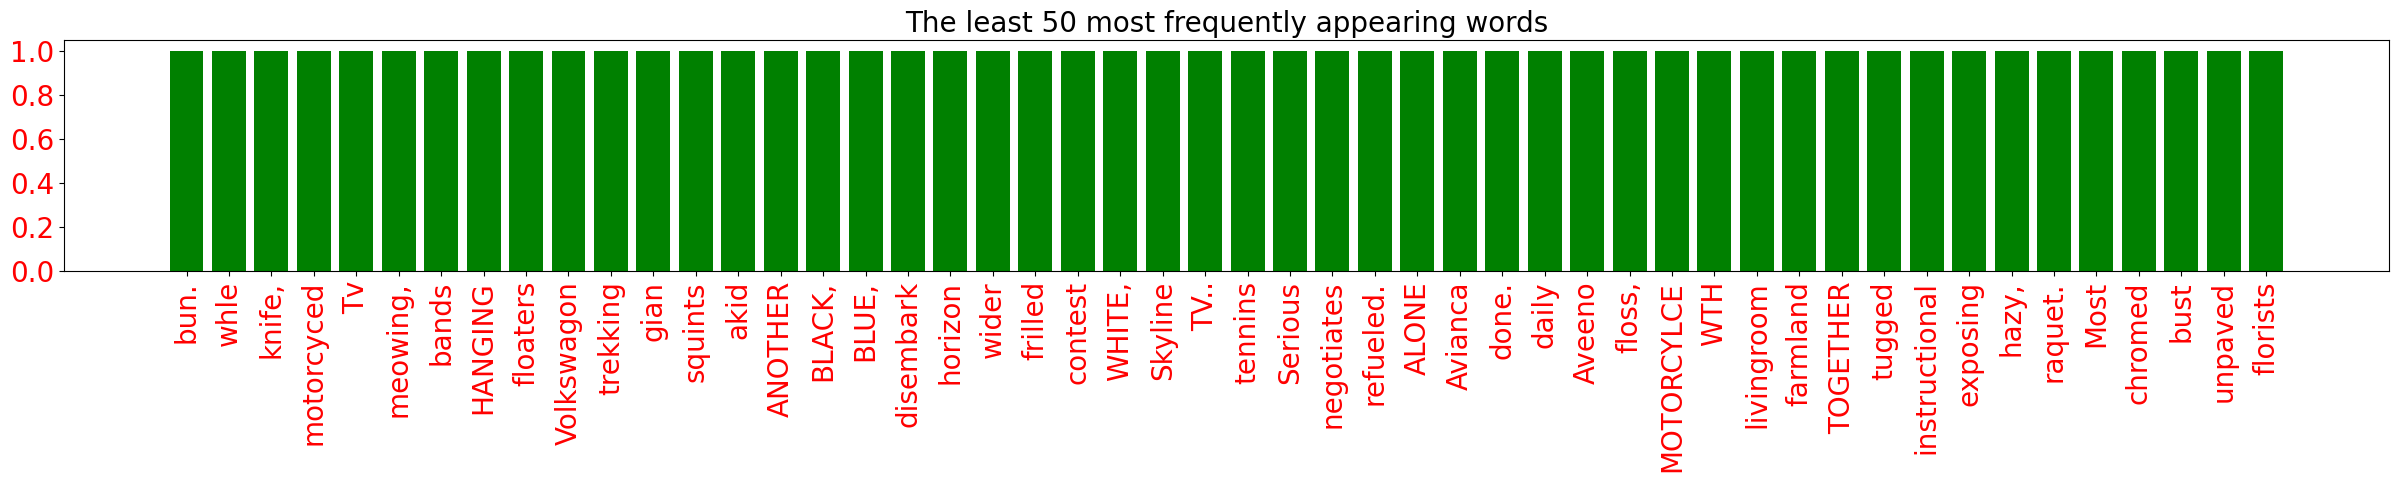

In [31]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"],color ='g')
    plt.yticks(fontsize=20,color ='r')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20,color ='r')
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfwordcount.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [32]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [33]:
clean_vocabulary = create_vocabulary(data)

Vocabulary Size : 9369


In [34]:
dfwordcount = df_word_count(data,clean_vocabulary)

In [35]:
word_freq = dfwordcount.set_index('word')['count'].to_dict()

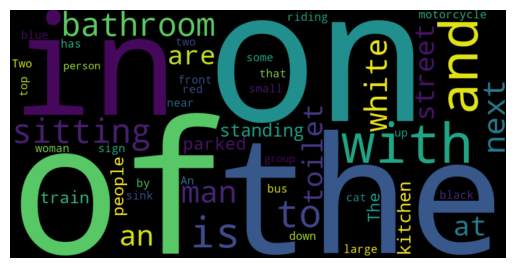

In [36]:
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(word_freq)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

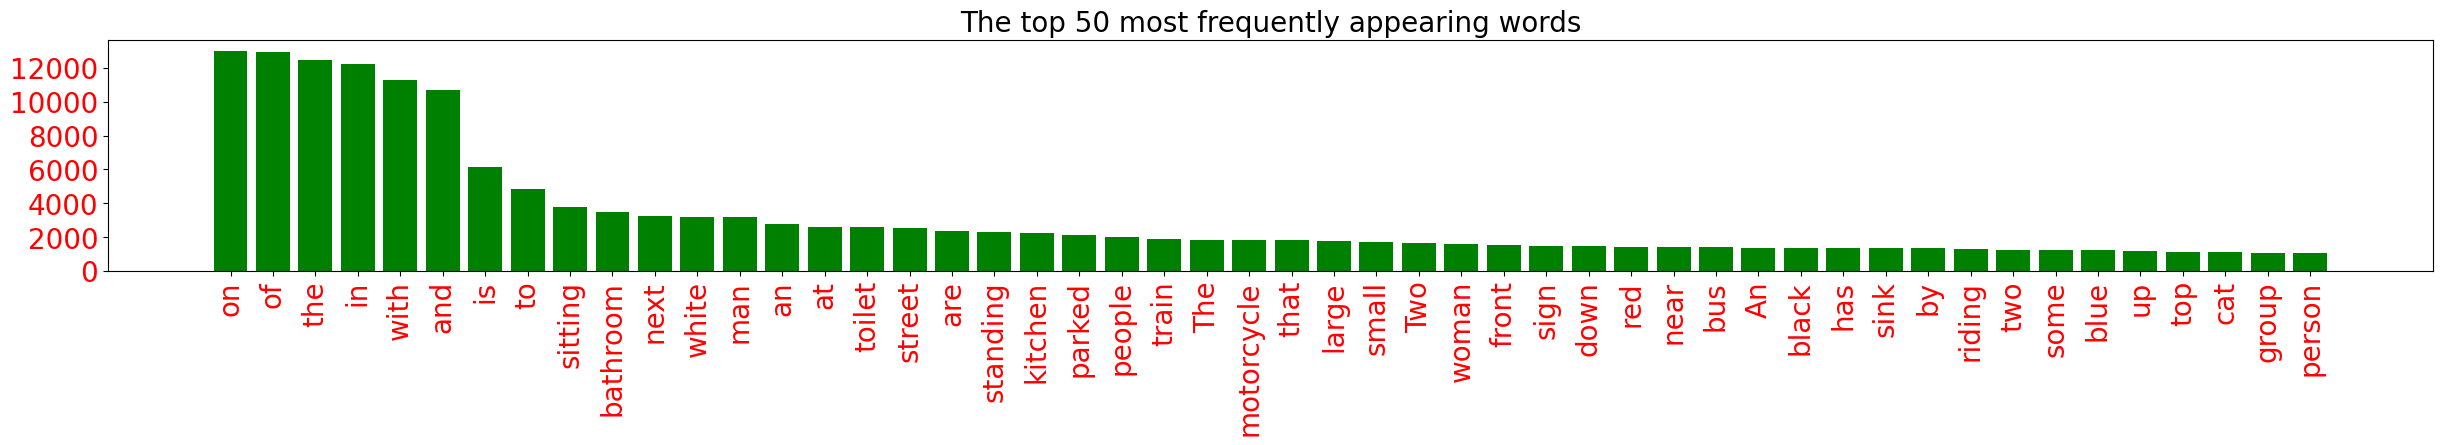

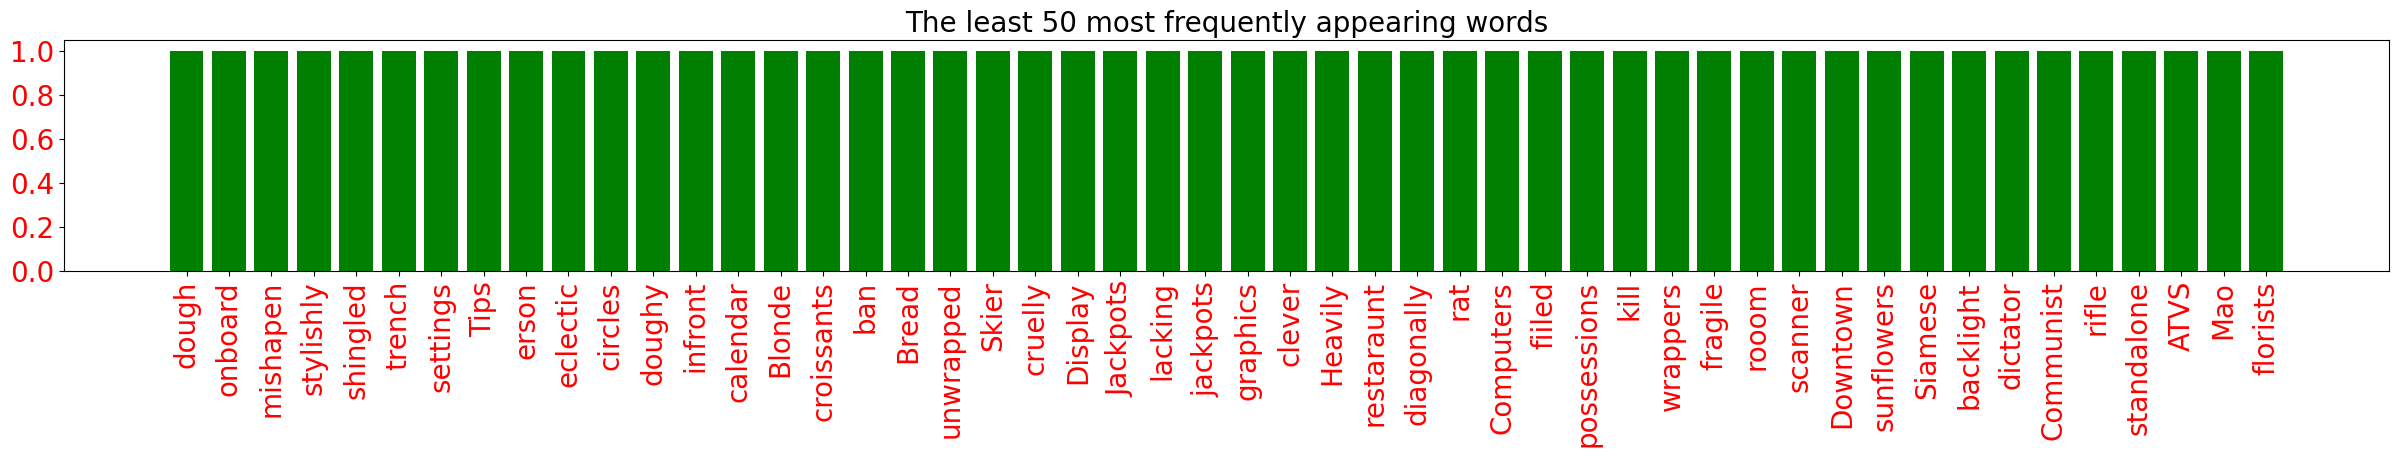

In [37]:
plthist(dfwordcount.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [38]:
def preprocess_images(data):
  all_img_name_vector = []

  for filenames in data["filename"]:
      full_image_path = filenames
      all_img_name_vector.append(full_image_path)
  return all_img_name_vector
all_img_name_vector = preprocess_images(data)
all_img_name_vector[:10]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000203564.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000322141.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000016977.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000106140.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000106140.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000322141.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000322141.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000322141.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000203564.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000016977.jpg']

In [39]:
def preprocess_captions(data):
  total_captions = []

  for caption  in data["caption"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(data)
total_captions[:10]

['<start>  bicycle replica with clock as the front <end>',
 '<start>  room with blue walls and white sink and <end>',
 '<start>  car that seems to be parked illegally behind legally parked car <end>',
 '<start>  large passenger airplane flying through the <end>',
 '<start>  There is GOL plane taking off in partly cloudy <end>',
 '<start>  Blue and white color scheme in small <end>',
 '<start>  This is blue and white bathroom with wall sink and lifesaver on the <end>',
 '<start>  blue boat themed bathroom with life preserver on the wall <end>',
 '<start>  The bike has clock as <end>',
 '<start>  two cars parked on the sidewalk on the street <end>']

In [40]:
images = all_img_name_vector[:20] 
unique_images = np.unique(images)
print(unique_images)

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000016977.jpg'
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000106140.jpg'
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000162113.jpg'
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000189634.jpg'
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000203564.jpg'
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000301837.jpg'
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000315702.jpg'
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000322141.jpg'
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000472598.jpg'
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000571635.jpg']


In [41]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(ten_images):
    fig = figure()
    number_of_files = len(ten_images)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(ten_images[i])
        imshow(image,cmap='Greys_r', aspect='equal', interpolation='nearest')
        axis('off')

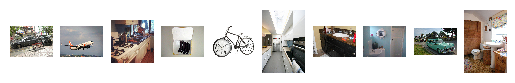

In [42]:
showImagesHorizontally(unique_images)

In [43]:
print("Total Images : " + str(len(all_img_name_vector)))
print("Total Captions : " + str(len(total_captions)))

Total Images : 40000
Total Captions : 40000


In [44]:
from pickle import dump

# save to file
dump(total_captions, open('captions.pkl', 'wb'))
dump(all_img_name_vector, open('img_names.pkl', 'wb'))

In [45]:
train_captions = load(open('captions.pkl', 'rb'))
img_name_vector = load(open('img_names.pkl', 'rb'))

In [46]:
# To know the shape of images
def img_shape_finder(image):
  img= plt.imread(image)

  print("Shape of the image  is ==> {0}".format(img.shape))

In [47]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])

In [48]:
for j in img_list:
  img_shape_finder(j)

Shape of the image  is ==> (400, 400, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (400, 400, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (640, 428, 3)
Shape of the image  is ==> (640, 427, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (480, 640, 3)
Shape of the image  is ==> (375, 500, 3)
Shape of the image  is ==> (332, 500, 3)
Shape of the image  is ==> (612, 612, 3)
Shape of the image  is ==> (400, 400, 3)


In [49]:
import tensorflow as tf

In [50]:
import imageio
def image_flipper(image):
  original_img = imageio.imread(image)
  
  plt.figure(1)

#Original Image

  plt.subplot(221)
  plt.imshow(original_img)

#Left-Right flip Image

  flipped_img_tensor = tf.image.flip_left_right(original_img)
  flipped_img= flipped_img_tensor.numpy()
  plt.subplot(222)
  plt.imshow(flipped_img)

#Up-Down flip Image

  upside_down_flip_tensor = tf.image.flip_up_down(original_img)
  upside_down_flip= upside_down_flip_tensor.numpy()
  plt.subplot(223)
  plt.imshow(upside_down_flip)

#Gray scale Image

  gray_tensor = tf.image.rgb_to_grayscale(original_img)
  grayimg= gray_tensor.numpy()
  plt.subplot(224)
  plt.imshow(tf.squeeze(grayimg))


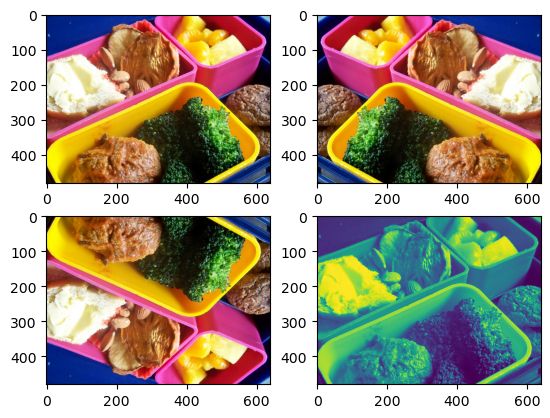

In [51]:
image_flipper('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000009.jpg')

Shape after resize : (224, 224, 3)


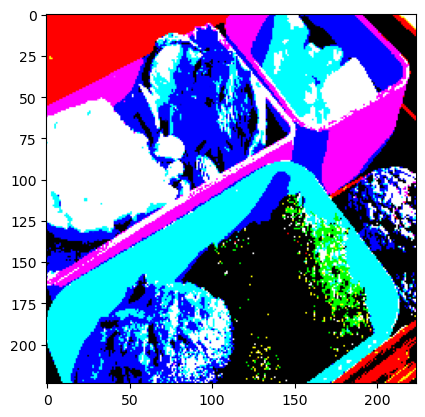

In [52]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

img1,img1_path = load_image('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000009.jpg')
print("Shape after resize :", img1.shape)
plt.imshow(img1)

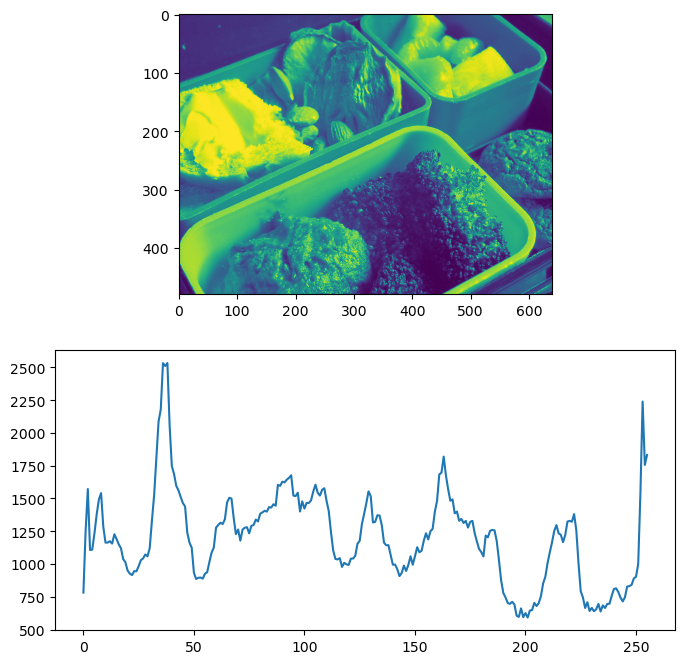

In [53]:
# importing required libraries of opencv 
import cv2 
# importing library for plotting 
from matplotlib import pyplot as plt 
def plot_image_histograms(image): 
  # reads an input image 
  img = cv2.imread(image,0) 
  # find frequency of pixels in range 0-255 
  histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
    
  # show the plotting graph of an image 
  fig = plt.figure(figsize=(8, 8))
  plt.subplot(2,1,1)
  plt.imshow(img)
  plt.subplot(2,1,2)
  plt.plot(histr) 
  plt.show() 

plot_image_histograms('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000009.jpg')

In [54]:
import tensorflow as tf
modelvgg = tf.keras.applications.VGG16(include_top=True,weights=None) # for observation on shapes

In [55]:
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [56]:
image_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
new_input = image_model.input # Any arbitrary shapes with 3 channels
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58889256/58889256 [==============================] - 2s 0us/step


In [57]:
image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [58]:
# Get unique images
encode_train = sorted(set(img_name_vector))
print(encode_train[:10])

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000073.jpg', '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000074.jpg', '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000136.jpg', '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000164.jpg', '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000328.jpg', '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000359.jpg', '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000472.jpg', '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000486.jpg', '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000520.jpg', '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000569.jpg']


In [59]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
#for files in image_dataset: 
    #print(files.numpy())

In [60]:
# Feel free to change batch_size according to your system configuration
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [61]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [62]:
from tqdm import tqdm

In [63]:
import tempfile
import os

In [64]:
temp_dir = tempfile.mkdtemp()

In [65]:
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = os.path.join(temp_dir, os.path.basename(p.numpy().decode("utf-8")) + '.npy')
        np.save(path_of_feature, bf.numpy())

100%|██████████| 126/126 [01:29<00:00,  1.40it/s]


In [66]:
def tokenize_caption(top_k,train_captions):
  # Choose the top 5000 words from the vocabulary
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  # oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
  
  tokenizer.fit_on_texts(train_captions)
  train_seqs = tokenizer.texts_to_sequences(train_captions)

  # Map '<pad>' to '0'
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'


  # Create the tokenized vectors
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs, tokenizer

train_seqs , tokenizer = tokenize_caption(5000,train_captions)

In [67]:
train_captions[:3]

['<start>  bicycle replica with clock as the front <end>',
 '<start>  room with blue walls and white sink and <end>',
 '<start>  car that seems to be parked illegally behind legally parked car <end>']

In [68]:
train_seqs[:3] # Here we can see that the sentences are converted to sequences

[[2, 113, 4593, 8, 137, 122, 4, 33, 3],
 [2, 70, 8, 45, 286, 9, 16, 42, 9, 3],
 [2, 60, 30, 985, 11, 266, 26, 3536, 112, 4594, 26, 60, 3]]

In [69]:
#tokenizer.index_word

In [70]:
#tokenizer.word_counts

In [71]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [72]:
# Find the maximum length of any caption in our dataset
def calc_min_length(tensor):
    return min(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
min_length = calc_min_length(train_seqs)

In [73]:
print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 42 : 4


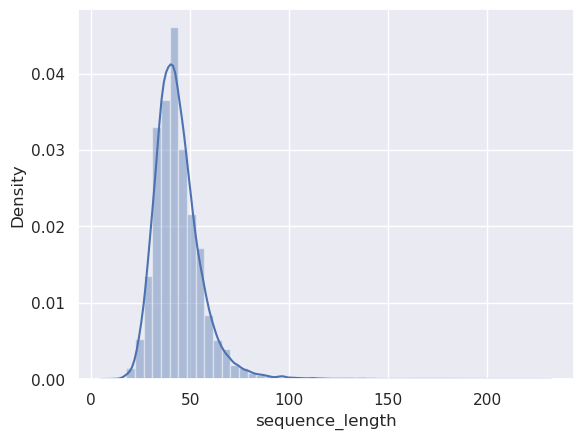

In [74]:
import seaborn as sns

df=pd.DataFrame()
df["sequence_length"] = data["caption"].apply(len)

sns.set()
distribution = sns.distplot(df["sequence_length"])

In [75]:
def padding_train_sequences(train_seqs,max_length,padding_type):
  cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
  return cap_vector

In [76]:
padded_caption_vector = padding_train_sequences(train_seqs,max_length,'post')
print(padded_caption_vector.shape)

(40000, 42)


In [77]:
padded_caption_vector

array([[   2,  113, 4593, ...,    0,    0,    0],
       [   2,   70,    8, ...,    0,    0,    0],
       [   2,   60,   30, ...,    0,    0,    0],
       ...,
       [   2,  202,    6, ...,    0,    0,    0],
       [   2,  989,   90, ...,    0,    0,    0],
       [   2,   85,  280, ...,    0,    0,    0]], dtype=int32)

In [78]:
# Create training and test set using an 80-20 split
img_name_train, img_name_test, caption_train, caption_test = train_test_split(img_name_vector,padded_caption_vector,test_size=0.2,random_state=0)

In [79]:
print("Training Data : X = {0},Y = {1}".format(len(img_name_train), len(caption_train)))
print("Test Data : X = {0},Y = {1}".format(len(img_name_test), len(caption_test)))

Training Data : X = 32000,Y = 32000
Test Data : X = 8000,Y = 8000


In [80]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [81]:
temp_dir

'/tmp/tmpxol1bzeo'

In [82]:
img_name_vector[:5]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000203564.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000322141.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000016977.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000106140.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000106140.jpg']

In [83]:
img_name_vector[0].split('/')[6]

'000000203564.jpg'

In [84]:
path_example = temp_dir + '/000000000074.jpg.npy'

In [85]:
np_img =np.load(path_example)

In [86]:
print(np_img)
print("Shape : {}".format(np_img.shape))

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 ...
 [ 0.        0.       10.837992 ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        2.032897  0.      ]]
Shape : (49, 512)


In [87]:
def load_npy(img_name, cap):
    img_tensor = np.load(temp_dir + '/' + img_name.decode('utf-8') + '.npy')
    return img_tensor, cap

In [88]:
def create_dataset(img_name_train,caption_train):

  
  dataset = tf.data.Dataset.from_tensor_slices((img_name_train, caption_train))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [89]:
img_name_train[1]

'/kaggle/input/coco-2017-dataset/coco2017/train2017/000000561088.jpg'

In [90]:
image_paths = []
for im in img_name_train:
    image_paths.append(im.split('/')[6])

In [91]:
image_paths2 = []
for im in img_name_test:
    image_paths2.append(im.split('/')[6])

In [92]:
# Creating train and test dataset
dataset = create_dataset(image_paths,caption_train)
test_dataset = create_dataset(image_paths2,caption_test)

In [93]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [94]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1 #8329
num_steps = len(img_name_train) // BATCH_SIZE  #500
EPOCHS = 20
# Shape from last layer of VGG-16 :(7,7,512)
# So, say there are 49 pixel locations now and each pixel is 512 dimensional
features_shape = 512
attention_features_shape = 49

In [95]:
# https://www.tensorflow.org/tutorials/text/image_captioning
class VGG16_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x        

In [96]:
def rnn_type(units):
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNGRU(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')

In [97]:
class Rnn_Local_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Rnn_Local_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    # Implementing Attention Mechanism 
    self.Uattn = tf.keras.layers.Dense(units)
    self.Wattn = tf.keras.layers.Dense(units)
    self.Vattn = tf.keras.layers.Dense(1)
    


  def call(self, x, features, hidden):
    
    # features shape ==> (64,49,256) ==> Output from ENCODER
    
    # hidden shape == (batch_size, hidden_size) ==>(64,512)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (64, 49, 1)
    # Attention Function
    '''e(ij) = f(s(t-1),h(j))'''
    ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
    # self.Uattn(features) : (64,49,512)
    # self.Wattn(hidden_with_time_axis) : (64,1,512)
    # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
    # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score
    # you get 1 at the last axis because you are applying score to self.Vattn
    
    
    # Then find Probability using Softmax
    '''attention_weights(alpha(ij)) = softmax(e(ij))'''
    attention_weights = tf.nn.softmax(score, axis=1)
    # attention_weights shape == (64, 49, 1)

    
    # Give weights to the different pixels in the image
    ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) ''' 
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
    # context_vector shape after sum == (64, 256)
    
    
    # x shape after passing through embedding == (64, 1, 256)
    x = self.embedding(x)
    
    # x shape after concatenation == (64, 1,  512)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # Adding Dropout and BatchNorm Layers
    x= self.dropout(x)
    x= self.batchnormalization(x)
    # output shape == (64 * 512)
    x = self.fc2(x)
    # shape : (64 * 8329(vocab))
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [98]:
def score_choose():
  scoring_type= input('Enter the scoring method: ')
  return scoring_type

In [99]:
scoring_type=score_choose()

Enter the scoring method:  global


In [100]:
class Rnn_Global_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size,scoring_type):
        super(Rnn_Global_Decoder, self).__init__()
        

        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        
        
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.wc = tf.keras.layers.Dense(units, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

        #For Attention
        self.wa = tf.keras.layers.Dense(units)
        self.wb = tf.keras.layers.Dense(units)
        
        #For Score 3 i.e. Concat score
        self.Vattn = tf.keras.layers.Dense(1)
        self.wd = tf.keras.layers.Dense(units, activation='tanh')

        self.scoring_type = scoring_type

        
    def call(self, sequence, features,hidden):
        
        # features : (64,49,256)
        # hidden : (64,512)
        
        embed = self.embedding(sequence)
        # embed ==> (64,1,256) ==> decoder_input after embedding (embedding dim=256)
       
        output, state = self.gru(embed)       
        #output :(64,1,512)

        score=0
        
        #Dot Score as per paper(Dot score : h_t (dot) h_s') (NB:just need to tweak gru units to 256)
        '''----------------------------------------------------------'''
        if(self.scoring_type=='dot'):
          xt=output #(64,1,512)
          xs=features #(256,49,64)  
          score = tf.matmul(xt, xs, transpose_b=True) 
               
          #score : (64,1,49)

        '''----------------------------------------------------------'''
        '''----------------------------------------------------------'''



        # General Score as per Paper ( General score: h_t (dot) Wa (dot) h_s')
        '''----------------------------------------------------------'''
        if(self.scoring_type=='general'):
          score = tf.matmul(output, self.wa(features), transpose_b=True)
          # score :(64,1,49)
        '''----------------------------------------------------------'''
        '''----------------------------------------------------------'''




        # Concat score as per paper (score: VT*tanh(W[ht;hs']))    
        '''----------------------------------------------------------'''
        #https://www.tensorflow.org/api_docs/python/tf/tile
        if(self.scoring_type=='concat'):
          tiled_features = tf.tile(features, [1,1,2]) #(64,49,512)
          tiled_output = tf.tile(output, [1,49,1]) #(64,49,512)
          
          concating_ht_hs = tf.concat([tiled_features,tiled_output],2) ##(64,49,1024)
          
          tanh_activated = self.wd(concating_ht_hs)
          score =self.Vattn(tanh_activated)
          #score :(64,49,1), but we want (64,1,49)
          score= tf.squeeze(score, 2)
          #score :(64,49)
          score = tf.expand_dims(score, 1)
          
          #score :(64,1,49)
        '''----------------------------------------------------------'''
        '''----------------------------------------------------------'''



        # alignment vector a_t
        alignment = tf.nn.softmax(score, axis=2)
        # alignment :(64,1,49)

        # context vector c_t is the average sum of encoder output
        context = tf.matmul(alignment, features)
        # context : (64,1,256)
        
        # Combine the context vector and the LSTM output
        
        output = tf.concat([tf.squeeze(context, 1), tf.squeeze(output, 1)], 1)
        # output: concat[(64,1,256):(64,1,512)] = (64,768)

        output = self.wc(output)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(output)
        # logits/predictions: (64,8239) i.e. (batch_size,vocab_size))

        return logits, state, alignment

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [101]:
attention_choice = input("Choose the type of Attention Mechanism you want to apply :")

Choose the type of Attention Mechanism you want to apply : local


In [102]:
if(attention_choice=='local'):
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

else:
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Global_Decoder(embedding_dim, units, vocab_size,scoring_type)

In [103]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [104]:
checkpoint_path_ckpt = "./checkpoint_finally19/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [105]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [106]:
!rm -rf ./logs/ 

In [107]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

In [108]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [109]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          #dec_input = tf.expand_dims(target[:, i], 1)
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
          

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  #train_loss(loss)
  #train_accuracy(target, predictions)

  return loss, total_loss

In [110]:
test_loss_plot = []

@tf.function
def test_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  features = encoder(img_tensor)

  for i in range(1, target.shape[1]):
      # passing the features through the decoder

      
      predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
      # predictions : (64,8329)
      loss += loss_function(target[:, i], predictions)
      
      predicted_id = tf.argmax(predictions[0])
      dec_input = tf.expand_dims([predicted_id]*BATCH_SIZE, 1)
 

  total_loss = (loss / int(target.shape[1]))

  return loss, total_loss

In [111]:
for epoch in range(start_epoch, 30):
    start = time.time()

    #For Train
    #================================================================
    total_loss_train = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss_train / num_steps)

    # Tensorboard 
    with train_summary_writer.as_default():
      tf.summary.scalar('LossPlotTrain', (total_loss_train/ num_steps), step=epoch)
      tf.summary.scalar('Train_loss', train_loss.result(), step=epoch)

    #For Test
    #================================================================
    total_loss_test = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
    # storing the epoch end loss value to plot later
    test_loss_plot.append(total_loss_test / num_steps) 

    # Tensorboard 
    with test_summary_writer.as_default():
      tf.summary.scalar('LossPlotTest', (total_loss_test/ num_steps), step=epoch)

    
    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(epoch + 1,(total_loss_train/num_steps),(total_loss_test/num_steps)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 TrainLoss 0.983730 TestLoss 0.296281
Time taken for 1 epoch 160.11742901802063 sec

Epoch 2 TrainLoss 0.781362 TestLoss 0.306138
Time taken for 1 epoch 70.15533304214478 sec

Epoch 3 TrainLoss 0.709542 TestLoss 0.312101
Time taken for 1 epoch 69.48846983909607 sec

Epoch 4 TrainLoss 0.659107 TestLoss 0.320047
Time taken for 1 epoch 71.03520226478577 sec

Epoch 5 TrainLoss 0.617508 TestLoss 0.330131
Time taken for 1 epoch 69.45237302780151 sec

Epoch 6 TrainLoss 0.580121 TestLoss 0.334388
Time taken for 1 epoch 70.09266471862793 sec

Epoch 7 TrainLoss 0.545745 TestLoss 0.343545
Time taken for 1 epoch 69.11204791069031 sec

Epoch 8 TrainLoss 0.514340 TestLoss 0.348213
Time taken for 1 epoch 69.43699502944946 sec

Epoch 9 TrainLoss 0.485887 TestLoss 0.356902
Time taken for 1 epoch 68.95566129684448 sec

Epoch 10 TrainLoss 0.460432 TestLoss 0.375287
Time taken for 1 epoch 69.8098087310791 sec

Epoch 11 TrainLoss 0.435978 TestLoss 0.385717
Time taken for 1 epoch 69.32857823371887 se

In [112]:
tokenizer.word_index['<start>']

2

In [113]:
%load_ext tensorboard
%tensorboard --logdir logs/gradient_tape

In [114]:
ckpt_manager.checkpoints

['./checkpoint_finally19/train/ckpt-2',
 './checkpoint_finally19/train/ckpt-3',
 './checkpoint_finally19/train/ckpt-4',
 './checkpoint_finally19/train/ckpt-5',
 './checkpoint_finally19/train/ckpt-6']

In [115]:
#ckpt.restore('./checkpoint_finally19/train/ckpt-4')

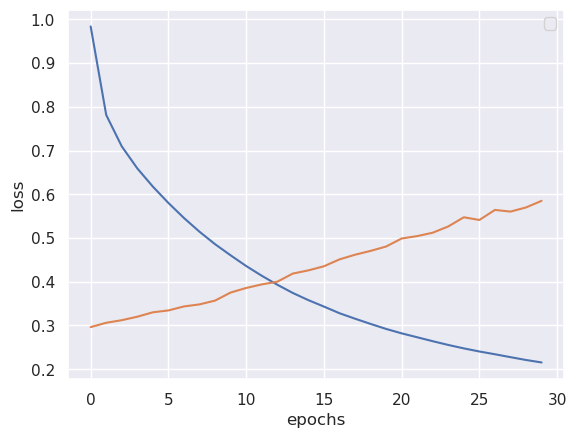

In [116]:
for label in [loss_plot,test_loss_plot]:
    plt.plot(label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [117]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) # Start token is <start> for LSTM
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id]) # Store the result or word predicted

        if tokenizer.index_word[predicted_id] == '<end>': # if you reach <end> token then return the result
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0) # Decoder input is the word predicted at previous timestep

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [118]:
def evaluate(image, beam_index = 3):

    start = [tokenizer.word_index['<start>']]
    
    # result[0][0] = index of the starting word
    # result[0][1] = probability of the word predicted
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:

          predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

          attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
          i=i+1
          # Getting the top <beam_index>(n) predictions
          word_preds = np.argsort(predictions[0])[-beam_index:]
          
          # creating a new list so as to put them via the model again
          for w in word_preds:       
            next_cap, prob = s[0][:], s[1]
            next_cap.append(w)
            prob += predictions[0][w]
            temp.append([next_cap, prob])
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]
        
        predicted_id = result[-1] # with Max Probability
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
          dec_input = tf.expand_dims([prd_id], 0)  # Decoder input is the word predicted with highest probability among the top_k words predicted
        else:
          break

    result = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption,attention_plot

In [119]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000048196.jpg
BELU score: 43.643578047198474
Real Caption: yellow bus with lion king ad on
Prediction Caption: yellow yellow bus with advertisement painted on
time took to Predict: 1 sec


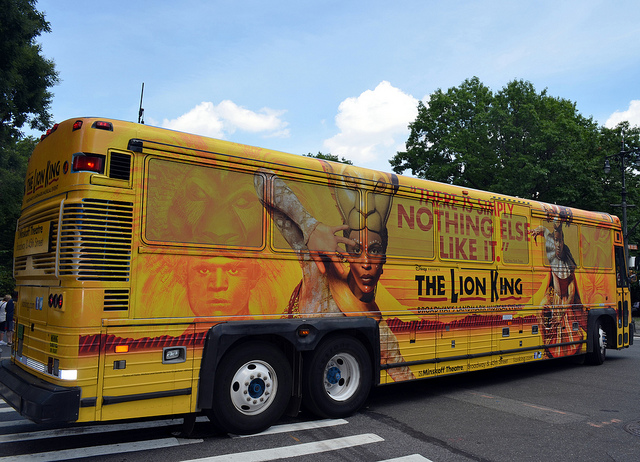

In [125]:
# captions on the validation set

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)
# We need to remove <end> and join the list elements into a sentence. Also we need to remove <unk> from real_captions


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ''.join(str(result))
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()


score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result_final, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])

In [121]:
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
print(real_caption)

<start> collection of poster arts lined up on the <end>


/kaggle/input/coco-2017-dataset/coco2017/train2017/000000449749.jpg
BELU score: 21.19738106741542
Real Caption: two black and while pelicans on the
Prediction Caption: two black birds are swimming
time took to Predict: 0 sec


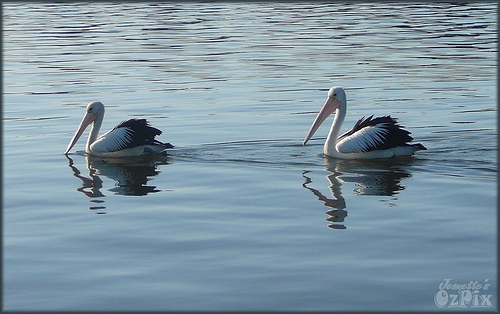

In [124]:
# captions on the validation set

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)
# We need to remove <end> and join the list elements into a sentence. Also we need to remove <unk> from real_captions


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ''.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])

/kaggle/input/coco-2017-dataset/coco2017/train2017/000000456574.jpg
BELU score: 24.761510494160163
Real Caption: group of men sitting on bench
Prediction Caption: some men sitting straddling
time took to Predict: 0 sec


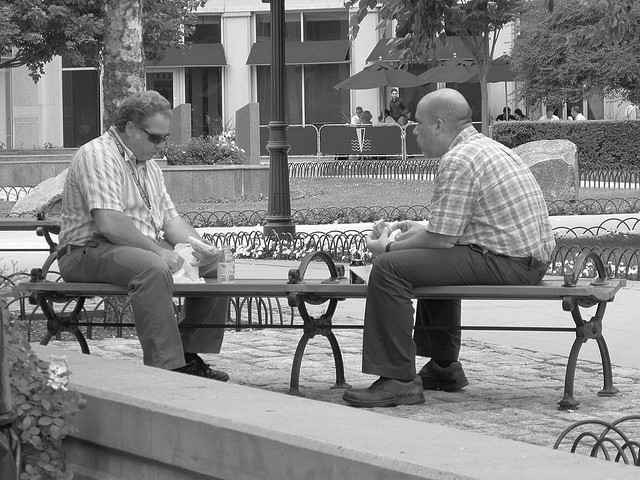

In [137]:
# captions on the validation set

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)
# We need to remove <end> and join the list elements into a sentence. Also we need to remove <unk> from real_captions


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ''.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])